In [37]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
from pydicom import Dataset
from PIL import Image
from tqdm import tqdm

from medmnist import BreastMNIST
from medmnist import INFO

import pennylane as qml

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using: {torch.cuda.get_device_name(0)}")
    print(f"CUDA: {torch.version.cuda}")
else:
    print("CUDA is not available. Using CPU.")

Using: NVIDIA GeForce RTX 4070 Ti SUPER
CUDA: 12.4


# **BreastMNIST**

In [39]:
info = INFO['breastmnist']
data_flag = 'breastmnist'
DataClass = BreastMNIST

task = info['task']  
n_channels = info['n_channels']
n_classes = len(info['label'])

print(f"Number of classes:", n_classes)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    lambda x: x.unsqueeze(0)
])

eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    lambda x: x.unsqueeze(0)
])

Number of classes: 2


## **Configuration for 28x28 and 64x64 Images**

In the following code, the dataset is configured to use images of size 28x28, which is the default setting for the BreastMNIST dataset (and other similar datasets like MedMNIST). 

In [40]:
data_train28 = DataClass(split='train', transform=train_transform, download=True)
data_test28 = DataClass(split='test', transform=eval_transform, download=True)
data_eval28 = DataClass(split='val', transform=eval_transform, download=True)

Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist.npz


For the case you want to use images of size 64x64, the code can be adjusted to load the dataset with this specific size by setting the `size` parameter to 64.

In [41]:
data_train64 = DataClass(split='train', transform=train_transform, download=True, size=64)
data_test64 = DataClass(split='test', transform=eval_transform, download=True, size=64)
data_eval64 = DataClass(split='val', transform=eval_transform, download=True, size=64)

Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_64.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_64.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_64.npz


In [42]:
data_train128 = DataClass(split='train', transform=train_transform, download=True, size=128)
data_test128 = DataClass(split='test', transform=eval_transform, download=True, size=128)
data_eval128 = DataClass(split='val', transform=eval_transform, download=True, size=128)

Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_128.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_128.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_128.npz


In [43]:
data_train224 = DataClass(split='train', transform=train_transform, download=True, size=224)
data_test224 = DataClass(split='test', transform=eval_transform, download=True, size=224)
data_eval224 = DataClass(split='val', transform=eval_transform, download=True, size=224)

Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_224.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_224.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_224.npz


## **Dataloader: Train, Test and Validation**

The following code snippet demonstrates how to load the training, test, and validation splits of the dataset:


In [44]:
batch_size = 32

dataloader_train = data.DataLoader(dataset=data_train224, batch_size=batch_size, shuffle=True)
dataloader_test = data.DataLoader(dataset=data_test224, batch_size=batch_size, shuffle=False)
dataloader_eval = data.DataLoader(dataset=data_eval224, batch_size=batch_size, shuffle=False)

print(f"\nNumber of images in training dataset: {len(data_train224)}")
print(f"Number of images in test dataset: {len(data_test224)}")
print(f"Number of images in validation dataset: {len(data_eval224)}")



Number of images in training dataset: 546
Number of images in test dataset: 156
Number of images in validation dataset: 78


# **Quanvolution**

Designed to process an image by applying a quantum circuit to extract features from it. It works similarly to a convolutional layer in a neural network, but instead of using traditional mathematical filters, it leverages a quantum circuit to process small patches of the image and generate new features.

In [45]:
def quanvolution(image, circuit, patch_size, n_qubits):
    """
    Perform quanvolution on the input image using the given quantum circuit.
    
    Args:
    - image (ndarray): The input image (2D or 3D with channels).
    - circuit (function): The quantum circuit function to extract features.
    - patch_size (int): The size of the patches to divide the image into.
    - n_qubits (int): Number of qubits in the quantum circuit.
    
    Returns:
    - out (ndarray): The output tensor after quanvolution.
    """
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    
    height_patches = image.shape[0] // patch_size
    width_patches = image.shape[1] // patch_size
    
    out = np.zeros((height_patches, width_patches, n_qubits))
    
    for j in range(height_patches):
        for k in range(width_patches):
            patch = []
            for i in range(patch_size):
                for l in range(patch_size):
                    if (j * patch_size + i < image.shape[0]) and (k * patch_size + l < image.shape[1]):
                        patch.append(image[j * patch_size + i, k * patch_size + l, 0])
                    else:
                        patch.append(0)
            
            q_results = circuit(patch)

            # Camada de atenção relacionar os patches e multiplicar atencao pelas features !!!
            
            for c in range(n_qubits):
                out[j, k, c] = q_results[c]
    
    return out

def quanvolution_batch(images, circuit, patch_size, n_qubits):
    """
    Applies quanvolution to a batch of images.

    Args:
    - images: Input tensor (batch_size, H, W, C).
    - circuit: Quantum circuit used for the quanvolution.
    - patch_size: Size of the patches used in the quanvolution.
    - n_qubits: Number of qubits in the quantum circuit.

    Returns:
    - Processed tensor after quanvolution.
    """
    batch_size = images.shape[0]
    processed = [
        quanvolution(images[i].detach().cpu().numpy(), circuit, patch_size, n_qubits)
        for i in range(batch_size)
    ]

    processed = np.array(processed)
    return torch.tensor(processed, dtype=torch.float32).to(images.device)

In [46]:
n_qubits = 4
n_layers = 1

rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubits))

def get_device(n_qubits):
    return qml.device("lightning.gpu", wires=n_qubits)

def define_circuit(rand_params):
    """
    Define a parametrized quantum circuit with custom layers and RandomLayers.

    Args:
    - rand_params: Parameters for the circuit layers.

    Returns:
    - A quantum circuit function (qml.QNode).
    """
    dev = get_device(n_qubits)

    @qml.qnode(dev, interface='torch')
    def circuit(phi):
        for j in range(n_qubits):
            qml.RY(np.pi * phi[j], wires=j)

        qml.templates.layers.RandomLayers(rand_params, list(range(n_qubits)))

        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

    return circuit

rand_circuit = define_circuit(rand_params)

phi = np.random.uniform(size=n_qubits)

result = rand_circuit(phi)

expanded_circuit = rand_circuit.qtape.expand()
print(expanded_circuit.draw())

0: ──RY────────────────┤  <Z>
1: ──RY──RY─╭●─────────┤  <Z>
2: ──RY──RX─│───RZ──RX─┤  <Z>
3: ──RY─────╰X─────────┤  <Z>


## **Quanvolution4x1**

*4 qubits & 1 quanvolution*

In [47]:
class Quanvolution4x1Model(nn.Module):
    def __init__(self, rand_params, output_size = (56, 56), patch_size = 4, n_qubits = 4, num_classes = 2):
        """
        Defines the CNN with quanvolution.

        Args:
        - rand_params: Parameters of the quantum circuit.
        - output_size: Output size after quanvolution.
        - n_qubits: Number of qubits in the quantum circuit.
        - num_classes: Number of classes for classification.
        """
        super(Quanvolution4x1Model, self).__init__()
        self.output_size = output_size
        self.patch_size = patch_size
        self.n_qubits = n_qubits
        self.num_classes = num_classes
        
        self.circuit = define_circuit(rand_params)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(output_size[0] * output_size[1] * n_qubits, num_classes)

    def forward(self, x):
        """
        Passes the data through the network.

        Args:
        - x: Input tensor (batch_size, C, H, W).
        
        Returns:
        - Logarithmic probabilities of the classes (batch_size, num_classes).
        """
        x = x.permute(0, 2, 3, 1)
        x = quanvolution_batch(x, self.circuit, self.patch_size, self.n_qubits)
        x = torch.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [48]:
model = Quanvolution4x1Model(rand_params).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 20

In [49]:
last_model_path = "/home/eflammere/BreastCancerQuanvolution/Quantum/checkpoints/BreastMNIST/224x224/1/last_model.pth"
checkpoint_frequency = 2

best_val_loss = float("inf")

train_losses = []

val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
val_aucs = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    model.train()
    total_loss = 0.0
    print("\n[Training]")
    for batch_idx, (images, labels) in enumerate(tqdm(dataloader_train, desc="Training Batches", bar_format="{desc}: {n}/{total}")):
        images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        batch_accuracy = accuracy_score(
            labels.cpu().numpy(), output.argmax(dim=1).cpu().numpy()
        )

        print(f"Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.3f}")

    epoch_train_loss = total_loss / len(dataloader_train)
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1} Training Loss: {epoch_train_loss:.4f}")

    scheduler.step()

    model.eval()
    val_loss = 0.0
    val_labels, val_predictions = [], []

    print("\n[Validation]")
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(dataloader_eval, desc="Validation Batches", bar_format="{desc}: {n}/{total}")):
            images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()

            val_labels.append(labels)
            val_predictions.append(output)

            batch_accuracy = accuracy_score(
                labels.cpu().numpy(), output.argmax(dim=1).cpu().numpy()
            )
            print(f"Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.3f}")

    epoch_val_loss = val_loss / len(dataloader_eval)
    val_losses.append(epoch_val_loss)
    val_labels = torch.cat(val_labels)
    val_predictions = torch.cat(val_predictions)

    val_accuracy = accuracy_score(
        val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy())
    val_precision = precision_score(
        val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(),
        average="weighted", zero_division=0)
    val_recall = recall_score(
        val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(),
        average="weighted", zero_division=0)
    val_f1 = f1_score(
        val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(),
        average="weighted", zero_division=0)
    val_auc = roc_auc_score(
        val_labels.cpu().numpy(), val_predictions[:, 1].cpu().numpy())

    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)
    val_aucs.append(val_auc)

    print(
        f"\nEpoch {epoch + 1} Summary:\n"
        f"Train Loss: {epoch_train_loss:.4f}, "
        f"Val Loss: {epoch_val_loss:.4f}, "
        f"Accuracy: {val_accuracy:.3f}, "
        f"Precision: {val_precision:.3f}, "
        f"Recall: {val_recall:.3f}, "
        f"F1: {val_f1:.3f}, "
        f"AUC: {val_auc:.3f}"
    )

    if (epoch + 1) % checkpoint_frequency == 0:
        checkpoint_path = f"/home/eflammere/BreastCancerQuanvolution/Quantum/checkpoints/BreastMNIST/224x224/1/model_checkpoint_epoch_{epoch + 1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved.")

torch.save(model.state_dict(), last_model_path)
print("Last model saved.")


Epoch 1/20

[Training]


Training Batches: 1/18

Loss: 0.6264, Accuracy: 0.812


Training Batches: 2/18

Loss: 14.5104, Accuracy: 0.750


Training Batches: 3/18

Loss: 19.8731, Accuracy: 0.656


Training Batches: 4/18

Loss: 8.4511, Accuracy: 0.719


Training Batches: 5/18

Loss: 1.8412, Accuracy: 0.562


Training Batches: 6/18

Loss: 9.3285, Accuracy: 0.438


Training Batches: 7/18

Loss: 7.3930, Accuracy: 0.250


Training Batches: 8/18

Loss: 2.2872, Accuracy: 0.750


Training Batches: 9/18

Loss: 5.3827, Accuracy: 0.781


Training Batches: 10/18

Loss: 8.6534, Accuracy: 0.750


Training Batches: 11/18

Loss: 10.7764, Accuracy: 0.719


Training Batches: 12/18

Loss: 9.3243, Accuracy: 0.688


Training Batches: 13/18

Loss: 6.2572, Accuracy: 0.688


Training Batches: 14/18

Loss: 2.1956, Accuracy: 0.719


Training Batches: 15/18

Loss: 5.6426, Accuracy: 0.531


Training Batches: 16/18

Loss: 9.6372, Accuracy: 0.438


Training Batches: 17/18

Loss: 7.8351, Accuracy: 0.469


Training Batches: 18/18


Loss: 8.3399, Accuracy: 0.000
Epoch 1 Training Loss: 7.6864

[Validation]


Validation Batches: 1/3

Loss: 2.5069, Accuracy: 0.781


Validation Batches: 2/3

Loss: 2.8839, Accuracy: 0.844


Validation Batches: 3/3


Loss: 1.5246, Accuracy: 0.714

Epoch 1 Summary:
Train Loss: 7.6864, Val Loss: 2.3051, Accuracy: 0.795, Precision: 0.785, Recall: 0.795, F1: 0.788, AUC: 0.751

Epoch 2/20

[Training]


Training Batches: 1/18

Loss: 1.4218, Accuracy: 0.781


Training Batches: 2/18

Loss: 3.2604, Accuracy: 0.812


Training Batches: 3/18

Loss: 3.6540, Accuracy: 0.781


Training Batches: 4/18

Loss: 5.7027, Accuracy: 0.719


Training Batches: 5/18

Loss: 9.8455, Accuracy: 0.562


Training Batches: 6/18

Loss: 4.2485, Accuracy: 0.688


Training Batches: 7/18

Loss: 4.2494, Accuracy: 0.406


Training Batches: 8/18

Loss: 6.0873, Accuracy: 0.375


Training Batches: 9/18

Loss: 6.5422, Accuracy: 0.469


Training Batches: 10/18

Loss: 5.2091, Accuracy: 0.500


Training Batches: 11/18

Loss: 3.5226, Accuracy: 0.688


Training Batches: 12/18

Loss: 4.1543, Accuracy: 0.781


Training Batches: 13/18

Loss: 5.6274, Accuracy: 0.781


Training Batches: 14/18

Loss: 6.1305, Accuracy: 0.812


Training Batches: 15/18

Loss: 8.6638, Accuracy: 0.656


Training Batches: 16/18

Loss: 3.0405, Accuracy: 0.844


Training Batches: 17/18

Loss: 3.4109, Accuracy: 0.812


Training Batches: 18/18


Loss: 0.0000, Accuracy: 1.000
Epoch 2 Training Loss: 4.7095

[Validation]


Validation Batches: 1/3

Loss: 2.7299, Accuracy: 0.750


Validation Batches: 2/3

Loss: 2.7534, Accuracy: 0.781


Validation Batches: 3/3


Loss: 1.4578, Accuracy: 0.786

Epoch 2 Summary:
Train Loss: 4.7095, Val Loss: 2.3137, Accuracy: 0.769, Precision: 0.794, Recall: 0.769, F1: 0.777, AUC: 0.767
Checkpoint saved.

Epoch 3/20

[Training]


Training Batches: 1/18

Loss: 3.8153, Accuracy: 0.625


Training Batches: 2/18

Loss: 4.3390, Accuracy: 0.719


Training Batches: 3/18

Loss: 4.2780, Accuracy: 0.469


Training Batches: 4/18

Loss: 4.2146, Accuracy: 0.656


Training Batches: 5/18

Loss: 3.5302, Accuracy: 0.656


Training Batches: 6/18

Loss: 3.3707, Accuracy: 0.750


Training Batches: 7/18

Loss: 4.0910, Accuracy: 0.656


Training Batches: 8/18

Loss: 2.0353, Accuracy: 0.875


Training Batches: 9/18

Loss: 1.7090, Accuracy: 0.812


Training Batches: 10/18

Loss: 3.2611, Accuracy: 0.719


Training Batches: 11/18

Loss: 1.1024, Accuracy: 0.906


Training Batches: 12/18

Loss: 2.1345, Accuracy: 0.625


Training Batches: 13/18

Loss: 1.8166, Accuracy: 0.594


Training Batches: 14/18

Loss: 1.8754, Accuracy: 0.750


Training Batches: 15/18

Loss: 1.5755, Accuracy: 0.812


Training Batches: 16/18

Loss: 2.0876, Accuracy: 0.719


Training Batches: 17/18

Loss: 2.9491, Accuracy: 0.750


Training Batches: 18/18


Loss: 0.0001, Accuracy: 1.000
Epoch 3 Training Loss: 2.6770

[Validation]


Validation Batches: 1/3

Loss: 1.4943, Accuracy: 0.875


Validation Batches: 2/3

Loss: 1.5804, Accuracy: 0.781


Validation Batches: 3/3


Loss: 0.6874, Accuracy: 0.714

Epoch 3 Summary:
Train Loss: 2.6770, Val Loss: 1.2540, Accuracy: 0.808, Precision: 0.818, Recall: 0.808, F1: 0.812, AUC: 0.795

Epoch 4/20

[Training]


Training Batches: 1/18

Loss: 2.8855, Accuracy: 0.781


Training Batches: 2/18

Loss: 1.7477, Accuracy: 0.719


Training Batches: 3/18

Loss: 2.7385, Accuracy: 0.594


Training Batches: 4/18

Loss: 1.3788, Accuracy: 0.750


Training Batches: 5/18

Loss: 0.5796, Accuracy: 0.812


Training Batches: 6/18

Loss: 0.7152, Accuracy: 0.812


Training Batches: 7/18

Loss: 2.3301, Accuracy: 0.781


Training Batches: 8/18

Loss: 2.0216, Accuracy: 0.844


Training Batches: 9/18

Loss: 3.2911, Accuracy: 0.719


Training Batches: 10/18

Loss: 2.3103, Accuracy: 0.688


Training Batches: 11/18

Loss: 2.1448, Accuracy: 0.688


Training Batches: 12/18

Loss: 2.8939, Accuracy: 0.594


Training Batches: 13/18

Loss: 2.4610, Accuracy: 0.656


Training Batches: 14/18

Loss: 0.9426, Accuracy: 0.750


Training Batches: 15/18

Loss: 0.7810, Accuracy: 0.844


Training Batches: 16/18

Loss: 2.6080, Accuracy: 0.781


Training Batches: 17/18

Loss: 5.8595, Accuracy: 0.688


Training Batches: 18/18


Loss: 0.0000, Accuracy: 1.000
Epoch 4 Training Loss: 2.0939

[Validation]


Validation Batches: 1/3

Loss: 1.3023, Accuracy: 0.844


Validation Batches: 2/3

Loss: 0.9946, Accuracy: 0.781


Validation Batches: 3/3


Loss: 3.4549, Accuracy: 0.429

Epoch 4 Summary:
Train Loss: 2.0939, Val Loss: 1.9173, Accuracy: 0.744, Precision: 0.718, Recall: 0.744, F1: 0.722, AUC: 0.759
Checkpoint saved.

Epoch 5/20

[Training]


Training Batches: 1/18

Loss: 1.3649, Accuracy: 0.844


Training Batches: 2/18

Loss: 2.3542, Accuracy: 0.719


Training Batches: 3/18

Loss: 5.8741, Accuracy: 0.406


Training Batches: 4/18

Loss: 1.8613, Accuracy: 0.531


Training Batches: 5/18

Loss: 0.9397, Accuracy: 0.781


Training Batches: 6/18

Loss: 3.3663, Accuracy: 0.719


Training Batches: 7/18

Loss: 2.5301, Accuracy: 0.781


Training Batches: 8/18

Loss: 3.5285, Accuracy: 0.750


Training Batches: 9/18

Loss: 1.2604, Accuracy: 0.750


Training Batches: 10/18

Loss: 1.0857, Accuracy: 0.750


Training Batches: 11/18

Loss: 3.0594, Accuracy: 0.531


Training Batches: 12/18

Loss: 2.5102, Accuracy: 0.625


Training Batches: 13/18

Loss: 1.3730, Accuracy: 0.781


Training Batches: 14/18

Loss: 2.1155, Accuracy: 0.812


Training Batches: 15/18

Loss: 1.0324, Accuracy: 0.875


Training Batches: 16/18

Loss: 3.0673, Accuracy: 0.750


Training Batches: 17/18

Loss: 2.0768, Accuracy: 0.719


Training Batches: 18/18


Loss: 4.1690, Accuracy: 0.500
Epoch 5 Training Loss: 2.4205

[Validation]


Validation Batches: 1/3

Loss: 1.5616, Accuracy: 0.875


Validation Batches: 2/3

Loss: 1.4604, Accuracy: 0.750


Validation Batches: 3/3


Loss: 1.8749, Accuracy: 0.786

Epoch 5 Summary:
Train Loss: 2.4205, Val Loss: 1.6323, Accuracy: 0.808, Precision: 0.806, Recall: 0.808, F1: 0.782, AUC: 0.797

Epoch 6/20

[Training]


Training Batches: 1/18

Loss: 1.2823, Accuracy: 0.875


Training Batches: 2/18

Loss: 0.7482, Accuracy: 0.875


Training Batches: 3/18

Loss: 1.9176, Accuracy: 0.750


Training Batches: 4/18

Loss: 1.7151, Accuracy: 0.781


Training Batches: 5/18

Loss: 0.3789, Accuracy: 0.844


Training Batches: 6/18

Loss: 1.4796, Accuracy: 0.875


Training Batches: 7/18

Loss: 1.1942, Accuracy: 0.812


Training Batches: 8/18

Loss: 1.0290, Accuracy: 0.844


Training Batches: 9/18

Loss: 0.7777, Accuracy: 0.781


Training Batches: 10/18

Loss: 2.3296, Accuracy: 0.625


Training Batches: 11/18

Loss: 1.2820, Accuracy: 0.656


Training Batches: 12/18

Loss: 1.3762, Accuracy: 0.719


Training Batches: 13/18

Loss: 1.4396, Accuracy: 0.688


Training Batches: 14/18

Loss: 1.1483, Accuracy: 0.781


Training Batches: 15/18

Loss: 0.5189, Accuracy: 0.750


Training Batches: 16/18

Loss: 1.2880, Accuracy: 0.656


Training Batches: 17/18

Loss: 0.6481, Accuracy: 0.781


Training Batches: 18/18


Loss: 1.4381, Accuracy: 0.500
Epoch 6 Training Loss: 1.2218

[Validation]


Validation Batches: 1/3

Loss: 1.1343, Accuracy: 0.781


Validation Batches: 2/3

Loss: 0.8481, Accuracy: 0.781


Validation Batches: 3/3


Loss: 1.4571, Accuracy: 0.714

Epoch 6 Summary:
Train Loss: 1.2218, Val Loss: 1.1465, Accuracy: 0.769, Precision: 0.769, Recall: 0.769, F1: 0.769, AUC: 0.812
Checkpoint saved.

Epoch 7/20

[Training]


Training Batches: 1/18

Loss: 0.3598, Accuracy: 0.875


Training Batches: 2/18

Loss: 1.2373, Accuracy: 0.688


Training Batches: 3/18

Loss: 1.2178, Accuracy: 0.719


Training Batches: 4/18

Loss: 1.5116, Accuracy: 0.594


Training Batches: 5/18

Loss: 0.8079, Accuracy: 0.844


Training Batches: 6/18

Loss: 0.8809, Accuracy: 0.844


Training Batches: 7/18

Loss: 1.3538, Accuracy: 0.844


Training Batches: 8/18

Loss: 1.6264, Accuracy: 0.812


Training Batches: 9/18

Loss: 1.1290, Accuracy: 0.844


Training Batches: 10/18

Loss: 0.9607, Accuracy: 0.844


Training Batches: 11/18

Loss: 0.7719, Accuracy: 0.906


Training Batches: 12/18

Loss: 0.8046, Accuracy: 0.781


Training Batches: 13/18

Loss: 1.6218, Accuracy: 0.781


Training Batches: 14/18

Loss: 1.1332, Accuracy: 0.719


Training Batches: 15/18

Loss: 0.8754, Accuracy: 0.812


Training Batches: 16/18

Loss: 0.9621, Accuracy: 0.844


Training Batches: 17/18

Loss: 0.3638, Accuracy: 0.906


Training Batches: 18/18


Loss: 0.0565, Accuracy: 1.000
Epoch 7 Training Loss: 0.9819

[Validation]


Validation Batches: 1/3

Loss: 1.0837, Accuracy: 0.750


Validation Batches: 2/3

Loss: 0.8748, Accuracy: 0.844


Validation Batches: 3/3


Loss: 1.4609, Accuracy: 0.643

Epoch 7 Summary:
Train Loss: 0.9819, Val Loss: 1.1398, Accuracy: 0.769, Precision: 0.816, Recall: 0.769, F1: 0.780, AUC: 0.818

Epoch 8/20

[Training]


Training Batches: 1/18

Loss: 1.3274, Accuracy: 0.656


Training Batches: 2/18

Loss: 1.3668, Accuracy: 0.625


Training Batches: 3/18

Loss: 0.4134, Accuracy: 0.812


Training Batches: 4/18

Loss: 1.4154, Accuracy: 0.750


Training Batches: 5/18

Loss: 0.5298, Accuracy: 0.875


Training Batches: 6/18

Loss: 0.7952, Accuracy: 0.812


Training Batches: 7/18

Loss: 0.1237, Accuracy: 0.906


Training Batches: 8/18

Loss: 1.3520, Accuracy: 0.625


Training Batches: 9/18

Loss: 0.6276, Accuracy: 0.844


Training Batches: 10/18

Loss: 0.9790, Accuracy: 0.812


Training Batches: 11/18

Loss: 0.8028, Accuracy: 0.812


Training Batches: 12/18

Loss: 2.1404, Accuracy: 0.688


Training Batches: 13/18

Loss: 1.1998, Accuracy: 0.688


Training Batches: 14/18

Loss: 0.8470, Accuracy: 0.844


Training Batches: 15/18

Loss: 1.6361, Accuracy: 0.719


Training Batches: 16/18

Loss: 1.1791, Accuracy: 0.781


Training Batches: 17/18

Loss: 0.6431, Accuracy: 0.781


Training Batches: 18/18


Loss: 0.2476, Accuracy: 1.000
Epoch 8 Training Loss: 0.9792

[Validation]


Validation Batches: 1/3

Loss: 1.0686, Accuracy: 0.750


Validation Batches: 2/3

Loss: 0.6645, Accuracy: 0.781


Validation Batches: 3/3


Loss: 1.2152, Accuracy: 0.643

Epoch 8 Summary:
Train Loss: 0.9792, Val Loss: 0.9828, Accuracy: 0.744, Precision: 0.752, Recall: 0.744, F1: 0.747, AUC: 0.805
Checkpoint saved.

Epoch 9/20

[Training]


Training Batches: 1/18

Loss: 1.2843, Accuracy: 0.656


Training Batches: 2/18

Loss: 1.0637, Accuracy: 0.781


Training Batches: 3/18

Loss: 0.7072, Accuracy: 0.844


Training Batches: 4/18

Loss: 1.4838, Accuracy: 0.531


Training Batches: 5/18

Loss: 0.6460, Accuracy: 0.750


Training Batches: 6/18

Loss: 1.0404, Accuracy: 0.719


Training Batches: 7/18

Loss: 0.5594, Accuracy: 0.812


Training Batches: 8/18

Loss: 0.7820, Accuracy: 0.781


Training Batches: 9/18

Loss: 0.9896, Accuracy: 0.688


Training Batches: 10/18

Loss: 0.6486, Accuracy: 0.812


Training Batches: 11/18

Loss: 0.4333, Accuracy: 0.812


Training Batches: 12/18

Loss: 1.0116, Accuracy: 0.719


Training Batches: 13/18

Loss: 0.8852, Accuracy: 0.781


Training Batches: 14/18

Loss: 1.2151, Accuracy: 0.750


Training Batches: 15/18

Loss: 1.0504, Accuracy: 0.750


Training Batches: 16/18

Loss: 1.1070, Accuracy: 0.750


Training Batches: 17/18

Loss: 0.1829, Accuracy: 0.875


Training Batches: 18/18


Loss: 0.3344, Accuracy: 1.000
Epoch 9 Training Loss: 0.8569

[Validation]


Validation Batches: 1/3

Loss: 1.2979, Accuracy: 0.812


Validation Batches: 2/3

Loss: 0.8732, Accuracy: 0.781


Validation Batches: 3/3


Loss: 1.2766, Accuracy: 0.571

Epoch 9 Summary:
Train Loss: 0.8569, Val Loss: 1.1492, Accuracy: 0.756, Precision: 0.731, Recall: 0.756, F1: 0.724, AUC: 0.801

Epoch 10/20

[Training]


Training Batches: 1/18

Loss: 0.9420, Accuracy: 0.812


Training Batches: 2/18

Loss: 0.5996, Accuracy: 0.812


Training Batches: 3/18

Loss: 1.3958, Accuracy: 0.688


Training Batches: 4/18

Loss: 0.9604, Accuracy: 0.719


Training Batches: 5/18

Loss: 1.2438, Accuracy: 0.781


Training Batches: 6/18

Loss: 0.6873, Accuracy: 0.812


Training Batches: 7/18

Loss: 0.6086, Accuracy: 0.781


Training Batches: 8/18

Loss: 1.1757, Accuracy: 0.688


Training Batches: 9/18

Loss: 1.0687, Accuracy: 0.719


Training Batches: 10/18

Loss: 0.5980, Accuracy: 0.875


Training Batches: 11/18

Loss: 0.8844, Accuracy: 0.688


Training Batches: 12/18

Loss: 0.7122, Accuracy: 0.781


Training Batches: 13/18

Loss: 0.8019, Accuracy: 0.688


Training Batches: 14/18

Loss: 0.3782, Accuracy: 0.844


Training Batches: 15/18

Loss: 0.3932, Accuracy: 0.906


Training Batches: 16/18

Loss: 0.7831, Accuracy: 0.781


Training Batches: 17/18

Loss: 0.2415, Accuracy: 0.938


Training Batches: 18/18


Loss: 0.2091, Accuracy: 1.000
Epoch 10 Training Loss: 0.7602

[Validation]


Validation Batches: 1/3

Loss: 1.1652, Accuracy: 0.812


Validation Batches: 2/3

Loss: 0.7054, Accuracy: 0.781


Validation Batches: 3/3


Loss: 0.9765, Accuracy: 0.643

Epoch 10 Summary:
Train Loss: 0.7602, Val Loss: 0.9491, Accuracy: 0.769, Precision: 0.750, Recall: 0.769, F1: 0.750, AUC: 0.821
Checkpoint saved.

Epoch 11/20

[Training]


Training Batches: 1/18

Loss: 0.8609, Accuracy: 0.750


Training Batches: 2/18

Loss: 0.5896, Accuracy: 0.875


Training Batches: 3/18

Loss: 0.7620, Accuracy: 0.812


Training Batches: 4/18

Loss: 0.8899, Accuracy: 0.812


Training Batches: 5/18

Loss: 0.6009, Accuracy: 0.781


Training Batches: 6/18

Loss: 0.6150, Accuracy: 0.781


Training Batches: 7/18

Loss: 0.3635, Accuracy: 0.844


Training Batches: 8/18

Loss: 0.2652, Accuracy: 0.844


Training Batches: 9/18

Loss: 0.8056, Accuracy: 0.750


Training Batches: 10/18

Loss: 0.5949, Accuracy: 0.844


Training Batches: 11/18

Loss: 0.8906, Accuracy: 0.844


Training Batches: 12/18

Loss: 0.6306, Accuracy: 0.812


Training Batches: 13/18

Loss: 0.5310, Accuracy: 0.844


Training Batches: 14/18

Loss: 0.8421, Accuracy: 0.875


Training Batches: 15/18

Loss: 1.0607, Accuracy: 0.750


Training Batches: 16/18

Loss: 0.9646, Accuracy: 0.781


Training Batches: 17/18

Loss: 1.0997, Accuracy: 0.719


Training Batches: 18/18


Loss: 1.1912, Accuracy: 0.500
Epoch 11 Training Loss: 0.7532

[Validation]


Validation Batches: 1/3

Loss: 1.0541, Accuracy: 0.844


Validation Batches: 2/3

Loss: 0.6175, Accuracy: 0.781


Validation Batches: 3/3


Loss: 0.9131, Accuracy: 0.714

Epoch 11 Summary:
Train Loss: 0.7532, Val Loss: 0.8616, Accuracy: 0.795, Precision: 0.783, Recall: 0.795, F1: 0.783, AUC: 0.820

Epoch 12/20

[Training]


Training Batches: 1/18

Loss: 0.6292, Accuracy: 0.812


Training Batches: 2/18

Loss: 0.4064, Accuracy: 0.875


Training Batches: 3/18

Loss: 0.3475, Accuracy: 0.844


Training Batches: 4/18

Loss: 0.4456, Accuracy: 0.875


Training Batches: 5/18

Loss: 1.3863, Accuracy: 0.688


Training Batches: 6/18

Loss: 0.2343, Accuracy: 0.875


Training Batches: 7/18

Loss: 0.8005, Accuracy: 0.781


Training Batches: 8/18

Loss: 0.2182, Accuracy: 0.906


Training Batches: 9/18

Loss: 0.6486, Accuracy: 0.812


Training Batches: 10/18

Loss: 0.8293, Accuracy: 0.812


Training Batches: 11/18

Loss: 0.2754, Accuracy: 0.812


Training Batches: 12/18

Loss: 0.6630, Accuracy: 0.750


Training Batches: 13/18

Loss: 0.8004, Accuracy: 0.781


Training Batches: 14/18

Loss: 1.0438, Accuracy: 0.750


Training Batches: 15/18

Loss: 1.0219, Accuracy: 0.688


Training Batches: 16/18

Loss: 0.9969, Accuracy: 0.750


Training Batches: 17/18

Loss: 0.5334, Accuracy: 0.844


Training Batches: 18/18


Loss: 7.9473, Accuracy: 0.500
Epoch 12 Training Loss: 1.0682

[Validation]


Validation Batches: 1/3

Loss: 1.0493, Accuracy: 0.844


Validation Batches: 2/3

Loss: 0.6064, Accuracy: 0.812


Validation Batches: 3/3


Loss: 0.9316, Accuracy: 0.714

Epoch 12 Summary:
Train Loss: 1.0682, Val Loss: 0.8624, Accuracy: 0.808, Precision: 0.798, Recall: 0.808, F1: 0.799, AUC: 0.814
Checkpoint saved.

Epoch 13/20

[Training]


Training Batches: 1/18

Loss: 0.7896, Accuracy: 0.750


Training Batches: 2/18

Loss: 0.5869, Accuracy: 0.781


Training Batches: 3/18

Loss: 0.7345, Accuracy: 0.750


Training Batches: 4/18

Loss: 1.0995, Accuracy: 0.688


Training Batches: 5/18

Loss: 0.6106, Accuracy: 0.781


Training Batches: 6/18

Loss: 0.8108, Accuracy: 0.781


Training Batches: 7/18

Loss: 0.6872, Accuracy: 0.812


Training Batches: 8/18

Loss: 0.4731, Accuracy: 0.844


Training Batches: 9/18

Loss: 0.8472, Accuracy: 0.844


Training Batches: 10/18

Loss: 0.8638, Accuracy: 0.750


Training Batches: 11/18

Loss: 0.3557, Accuracy: 0.875


Training Batches: 12/18

Loss: 0.9001, Accuracy: 0.750


Training Batches: 13/18

Loss: 0.4627, Accuracy: 0.844


Training Batches: 14/18

Loss: 0.5563, Accuracy: 0.812


Training Batches: 15/18

Loss: 1.0957, Accuracy: 0.719


Training Batches: 16/18

Loss: 0.9503, Accuracy: 0.781


Training Batches: 17/18

Loss: 0.8569, Accuracy: 0.688


Training Batches: 18/18


Loss: 0.0114, Accuracy: 1.000
Epoch 13 Training Loss: 0.7051

[Validation]


Validation Batches: 1/3

Loss: 1.0576, Accuracy: 0.844


Validation Batches: 2/3

Loss: 0.6123, Accuracy: 0.750


Validation Batches: 3/3


Loss: 0.9683, Accuracy: 0.714

Epoch 13 Summary:
Train Loss: 0.7051, Val Loss: 0.8794, Accuracy: 0.782, Precision: 0.774, Recall: 0.782, F1: 0.776, AUC: 0.808

Epoch 14/20

[Training]


Training Batches: 1/18

Loss: 0.2872, Accuracy: 0.875


Training Batches: 2/18

Loss: 0.5575, Accuracy: 0.875


Training Batches: 3/18

Loss: 0.9652, Accuracy: 0.781


Training Batches: 4/18

Loss: 0.8307, Accuracy: 0.812


Training Batches: 5/18

Loss: 0.8593, Accuracy: 0.719


Training Batches: 6/18

Loss: 1.0440, Accuracy: 0.719


Training Batches: 7/18

Loss: 1.0183, Accuracy: 0.781


Training Batches: 8/18

Loss: 0.8514, Accuracy: 0.750


Training Batches: 9/18

Loss: 0.6662, Accuracy: 0.750


Training Batches: 10/18

Loss: 0.6897, Accuracy: 0.812


Training Batches: 11/18

Loss: 0.3889, Accuracy: 0.938


Training Batches: 12/18

Loss: 1.1160, Accuracy: 0.719


Training Batches: 13/18

Loss: 0.7176, Accuracy: 0.719


Training Batches: 14/18

Loss: 0.6032, Accuracy: 0.812


Training Batches: 15/18

Loss: 0.6290, Accuracy: 0.750


Training Batches: 16/18

Loss: 0.8718, Accuracy: 0.750


Training Batches: 17/18

Loss: 0.1701, Accuracy: 0.906


Training Batches: 18/18


Loss: 0.5471, Accuracy: 0.500
Epoch 14 Training Loss: 0.7118

[Validation]


Validation Batches: 1/3

Loss: 1.0918, Accuracy: 0.844


Validation Batches: 2/3

Loss: 0.6116, Accuracy: 0.781


Validation Batches: 3/3


Loss: 0.9706, Accuracy: 0.714

Epoch 14 Summary:
Train Loss: 0.7118, Val Loss: 0.8913, Accuracy: 0.795, Precision: 0.783, Recall: 0.795, F1: 0.783, AUC: 0.805
Checkpoint saved.

Epoch 15/20

[Training]


Training Batches: 1/18

Loss: 0.5542, Accuracy: 0.781


Training Batches: 2/18

Loss: 0.8596, Accuracy: 0.656


Training Batches: 3/18

Loss: 0.4631, Accuracy: 0.844


Training Batches: 4/18

Loss: 0.8254, Accuracy: 0.750


Training Batches: 5/18

Loss: 0.8912, Accuracy: 0.750


Training Batches: 6/18

Loss: 0.3836, Accuracy: 0.844


Training Batches: 7/18

Loss: 0.7849, Accuracy: 0.719


Training Batches: 8/18

Loss: 0.7518, Accuracy: 0.781


Training Batches: 9/18

Loss: 0.2265, Accuracy: 0.875


Training Batches: 10/18

Loss: 0.3141, Accuracy: 0.875


Training Batches: 11/18

Loss: 0.4147, Accuracy: 0.875


Training Batches: 12/18

Loss: 0.3349, Accuracy: 0.875


Training Batches: 13/18

Loss: 0.9387, Accuracy: 0.781


Training Batches: 14/18

Loss: 1.2638, Accuracy: 0.750


Training Batches: 15/18

Loss: 0.9372, Accuracy: 0.656


Training Batches: 16/18

Loss: 0.3926, Accuracy: 0.781


Training Batches: 17/18

Loss: 1.0959, Accuracy: 0.750


Training Batches: 18/18


Loss: 0.0187, Accuracy: 1.000
Epoch 15 Training Loss: 0.6362

[Validation]


Validation Batches: 1/3

Loss: 1.1328, Accuracy: 0.844


Validation Batches: 2/3

Loss: 0.6288, Accuracy: 0.781


Validation Batches: 3/3


Loss: 0.9914, Accuracy: 0.714

Epoch 15 Summary:
Train Loss: 0.6362, Val Loss: 0.9177, Accuracy: 0.795, Precision: 0.783, Recall: 0.795, F1: 0.783, AUC: 0.804

Epoch 16/20

[Training]


Training Batches: 1/18

Loss: 0.5395, Accuracy: 0.812


Training Batches: 2/18

Loss: 0.7453, Accuracy: 0.750


Training Batches: 3/18

Loss: 0.7134, Accuracy: 0.781


Training Batches: 4/18

Loss: 1.1599, Accuracy: 0.750


Training Batches: 5/18

Loss: 0.7811, Accuracy: 0.812


Training Batches: 6/18

Loss: 0.9395, Accuracy: 0.781


Training Batches: 7/18

Loss: 0.6439, Accuracy: 0.781


Training Batches: 8/18

Loss: 0.7304, Accuracy: 0.812


Training Batches: 9/18

Loss: 0.4636, Accuracy: 0.938


Training Batches: 10/18

Loss: 1.0552, Accuracy: 0.844


Training Batches: 11/18

Loss: 0.6881, Accuracy: 0.844


Training Batches: 12/18

Loss: 0.6747, Accuracy: 0.781


Training Batches: 13/18

Loss: 0.5856, Accuracy: 0.812


Training Batches: 14/18

Loss: 0.8008, Accuracy: 0.781


Training Batches: 15/18

Loss: 0.6089, Accuracy: 0.750


Training Batches: 16/18

Loss: 0.4713, Accuracy: 0.719


Training Batches: 17/18

Loss: 0.7906, Accuracy: 0.812


Training Batches: 18/18


Loss: 0.0056, Accuracy: 1.000
Epoch 16 Training Loss: 0.6887

[Validation]


Validation Batches: 1/3

Loss: 1.1189, Accuracy: 0.844


Validation Batches: 2/3

Loss: 0.6167, Accuracy: 0.781


Validation Batches: 3/3


Loss: 0.9876, Accuracy: 0.714

Epoch 16 Summary:
Train Loss: 0.6887, Val Loss: 0.9078, Accuracy: 0.795, Precision: 0.783, Recall: 0.795, F1: 0.783, AUC: 0.805
Checkpoint saved.

Epoch 17/20

[Training]


Training Batches: 1/18

Loss: 0.8777, Accuracy: 0.719


Training Batches: 2/18

Loss: 1.0773, Accuracy: 0.688


Training Batches: 3/18

Loss: 0.2615, Accuracy: 0.906


Training Batches: 4/18

Loss: 0.2373, Accuracy: 0.938


Training Batches: 5/18

Loss: 0.7335, Accuracy: 0.844


Training Batches: 6/18

Loss: 0.9704, Accuracy: 0.719


Training Batches: 7/18

Loss: 0.5072, Accuracy: 0.844


Training Batches: 8/18

Loss: 0.5721, Accuracy: 0.812


Training Batches: 9/18

Loss: 1.1610, Accuracy: 0.656


Training Batches: 10/18

Loss: 1.3883, Accuracy: 0.688


Training Batches: 11/18

Loss: 0.3415, Accuracy: 0.906


Training Batches: 12/18

Loss: 0.6829, Accuracy: 0.875


Training Batches: 13/18

Loss: 0.8070, Accuracy: 0.781


Training Batches: 14/18

Loss: 0.5165, Accuracy: 0.875


Training Batches: 15/18

Loss: 0.6927, Accuracy: 0.844


Training Batches: 16/18

Loss: 0.8256, Accuracy: 0.844


Training Batches: 17/18

Loss: 0.6486, Accuracy: 0.719


Training Batches: 18/18


Loss: 0.0005, Accuracy: 1.000
Epoch 17 Training Loss: 0.6834

[Validation]


Validation Batches: 1/3

Loss: 1.1079, Accuracy: 0.844


Validation Batches: 2/3

Loss: 0.6087, Accuracy: 0.781


Validation Batches: 3/3


Loss: 0.9847, Accuracy: 0.714

Epoch 17 Summary:
Train Loss: 0.6834, Val Loss: 0.9004, Accuracy: 0.795, Precision: 0.783, Recall: 0.795, F1: 0.783, AUC: 0.805

Epoch 18/20

[Training]


Training Batches: 1/18

Loss: 0.9726, Accuracy: 0.656


Training Batches: 2/18

Loss: 0.7132, Accuracy: 0.812


Training Batches: 3/18

Loss: 0.6414, Accuracy: 0.844


Training Batches: 4/18

Loss: 0.5645, Accuracy: 0.844


Training Batches: 5/18

Loss: 0.9555, Accuracy: 0.812


Training Batches: 6/18

Loss: 0.7539, Accuracy: 0.812


Training Batches: 7/18

Loss: 1.6468, Accuracy: 0.719


Training Batches: 8/18

Loss: 0.3325, Accuracy: 0.812


Training Batches: 9/18

Loss: 0.7924, Accuracy: 0.781


Training Batches: 10/18

Loss: 0.5454, Accuracy: 0.812


Training Batches: 11/18

Loss: 0.3254, Accuracy: 0.875


Training Batches: 12/18

Loss: 0.6236, Accuracy: 0.812


Training Batches: 13/18

Loss: 0.5654, Accuracy: 0.844


Training Batches: 14/18

Loss: 0.5929, Accuracy: 0.812


Training Batches: 15/18

Loss: 0.5476, Accuracy: 0.688


Training Batches: 16/18

Loss: 0.9161, Accuracy: 0.719


Training Batches: 17/18

Loss: 0.8386, Accuracy: 0.688


Training Batches: 18/18


Loss: 2.0884, Accuracy: 0.500
Epoch 18 Training Loss: 0.8009

[Validation]


Validation Batches: 1/3

Loss: 1.1032, Accuracy: 0.844


Validation Batches: 2/3

Loss: 0.6051, Accuracy: 0.812


Validation Batches: 3/3


Loss: 0.9850, Accuracy: 0.714

Epoch 18 Summary:
Train Loss: 0.8009, Val Loss: 0.8978, Accuracy: 0.808, Precision: 0.798, Recall: 0.808, F1: 0.799, AUC: 0.805
Checkpoint saved.

Epoch 19/20

[Training]


Training Batches: 1/18

Loss: 0.6850, Accuracy: 0.812


Training Batches: 2/18

Loss: 0.3836, Accuracy: 0.906


Training Batches: 3/18

Loss: 0.6742, Accuracy: 0.875


Training Batches: 4/18

Loss: 0.6817, Accuracy: 0.719


Training Batches: 5/18

Loss: 1.2139, Accuracy: 0.812


Training Batches: 6/18

Loss: 0.6096, Accuracy: 0.719


Training Batches: 7/18

Loss: 1.3733, Accuracy: 0.719


Training Batches: 8/18

Loss: 1.0646, Accuracy: 0.812


Training Batches: 9/18

Loss: 0.6459, Accuracy: 0.812


Training Batches: 10/18

Loss: 0.5117, Accuracy: 0.812


Training Batches: 11/18

Loss: 1.1307, Accuracy: 0.719


Training Batches: 12/18

Loss: 0.3987, Accuracy: 0.875


Training Batches: 13/18

Loss: 0.6207, Accuracy: 0.781


Training Batches: 14/18

Loss: 0.9858, Accuracy: 0.781


Training Batches: 15/18

Loss: 0.6819, Accuracy: 0.719


Training Batches: 16/18

Loss: 0.4886, Accuracy: 0.844


Training Batches: 17/18

Loss: 0.5397, Accuracy: 0.812


Training Batches: 18/18


Loss: 0.0039, Accuracy: 1.000
Epoch 19 Training Loss: 0.7052

[Validation]


Validation Batches: 1/3

Loss: 1.0930, Accuracy: 0.844


Validation Batches: 2/3

Loss: 0.5967, Accuracy: 0.812


Validation Batches: 3/3


Loss: 0.9883, Accuracy: 0.714

Epoch 19 Summary:
Train Loss: 0.7052, Val Loss: 0.8927, Accuracy: 0.808, Precision: 0.798, Recall: 0.808, F1: 0.799, AUC: 0.803

Epoch 20/20

[Training]


Training Batches: 1/18

Loss: 0.2634, Accuracy: 0.906


Training Batches: 2/18

Loss: 0.7566, Accuracy: 0.812


Training Batches: 3/18

Loss: 0.6624, Accuracy: 0.781


Training Batches: 4/18

Loss: 0.6186, Accuracy: 0.719


Training Batches: 5/18

Loss: 0.5864, Accuracy: 0.812


Training Batches: 6/18

Loss: 0.7432, Accuracy: 0.812


Training Batches: 7/18

Loss: 0.5037, Accuracy: 0.812


Training Batches: 8/18

Loss: 0.6936, Accuracy: 0.781


Training Batches: 9/18

Loss: 1.1188, Accuracy: 0.719


Training Batches: 10/18

Loss: 0.9854, Accuracy: 0.688


Training Batches: 11/18

Loss: 0.5870, Accuracy: 0.781


Training Batches: 12/18

Loss: 0.4901, Accuracy: 0.812


Training Batches: 13/18

Loss: 0.8733, Accuracy: 0.719


Training Batches: 14/18

Loss: 0.6286, Accuracy: 0.812


Training Batches: 15/18

Loss: 0.3110, Accuracy: 0.781


Training Batches: 16/18

Loss: 0.8847, Accuracy: 0.719


Training Batches: 17/18

Loss: 0.4578, Accuracy: 0.844


Training Batches: 18/18


Loss: 0.2284, Accuracy: 1.000
Epoch 20 Training Loss: 0.6329

[Validation]


Validation Batches: 1/3

Loss: 1.0910, Accuracy: 0.844


Validation Batches: 2/3

Loss: 0.5952, Accuracy: 0.812


Validation Batches: 3/3

Loss: 0.9866, Accuracy: 0.714

Epoch 20 Summary:
Train Loss: 0.6329, Val Loss: 0.8909, Accuracy: 0.808, Precision: 0.798, Recall: 0.808, F1: 0.799, AUC: 0.803
Checkpoint saved.
Last model saved.


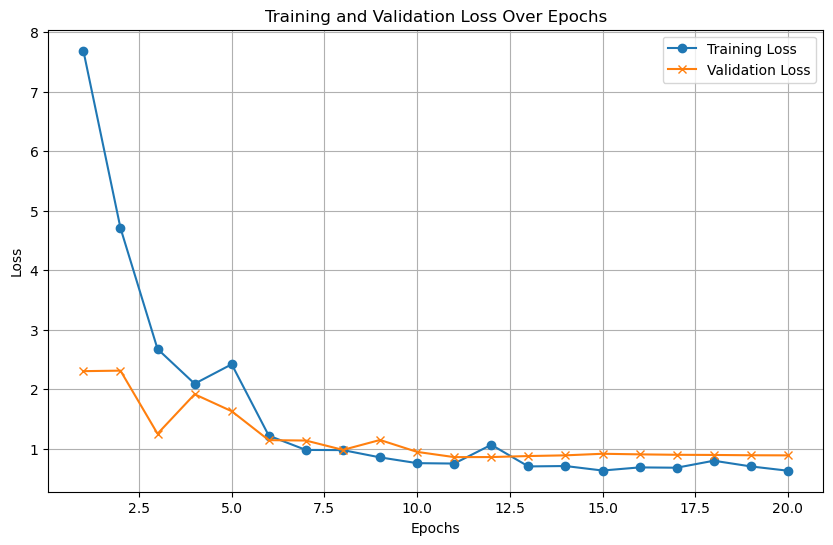

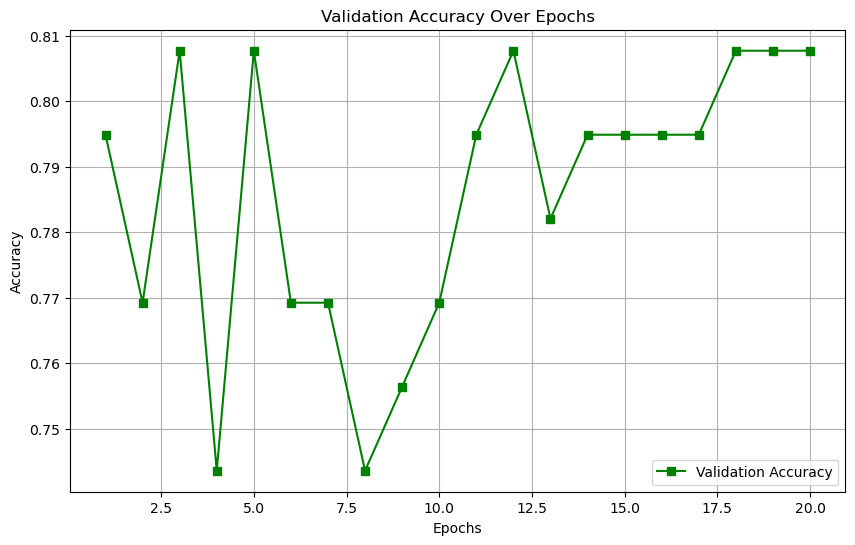

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", marker='s', color='g')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

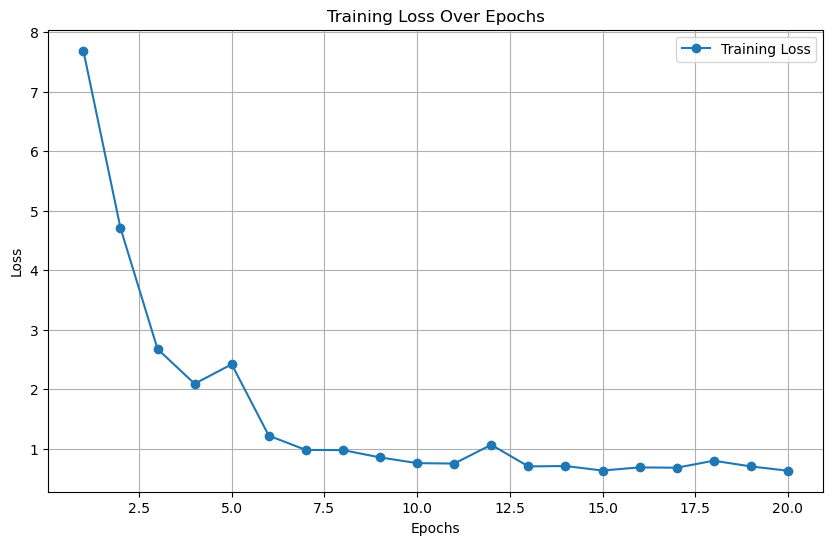

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# model_path = "/home/eflammere/BreastCancerQuanvolution/Quantum/checkpoints/BreastMNIST/28x28/best_model.pth"
# model.load_state_dict(torch.load(model_path, weights_only=True))

test_loss = 0.0
test_labels, test_predictions = [], []

model.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)
        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item()
        test_labels.append(labels)
        test_predictions.append(output)

test_labels = torch.cat(test_labels)
test_predictions = torch.cat(test_predictions)

test_probs = torch.exp(test_predictions)

test_accuracy = accuracy_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy()
)
test_precision = precision_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), 
    average="weighted", zero_division=0
)
test_recall = recall_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), 
    average="weighted", zero_division=0
)
test_f1 = f1_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), 
    average="weighted", zero_division=0
)
test_auc = roc_auc_score(
    test_labels.cpu().numpy(), test_probs[:, 1].cpu().numpy()
)

print("\nFinal Test Evaluation:")
print(f"Test Loss: {test_loss / len(dataloader_test):.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")



Final Test Evaluation:
Test Loss: 1.0078
Test Accuracy: 0.7692
Test Precision: 0.7628
Test Recall: 0.7692
Test F1 Score: 0.7655
Test AUC: 0.7706


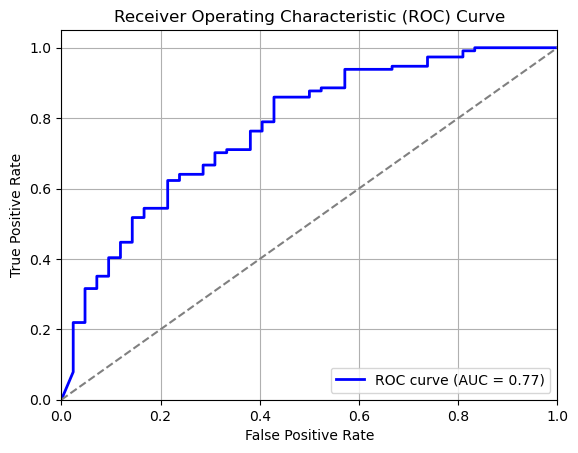

ROC curve data exported to 'roc_curve_data_BreastMNIST.csv'


In [53]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(
    test_labels.cpu().numpy(), test_probs[:, 1].cpu().numpy()
)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

dataset_name = "BreastMNIST"
roc_data = pd.DataFrame({
    'Dataset': [dataset_name] * len(false_positive_rate),
    'False Positive Rate': false_positive_rate,
    'True Positive Rate': true_positive_rate,
    'Thresholds': thresholds
})
roc_data.to_csv(f'/home/eflammere/BreastCancerQuanvolution/Quantum/checkpoints/BreastMNIST/224x224/1/roc_curve_data_{dataset_name}.csv', index=False)

print(f"ROC curve data exported to 'roc_curve_data_{dataset_name}.csv'")


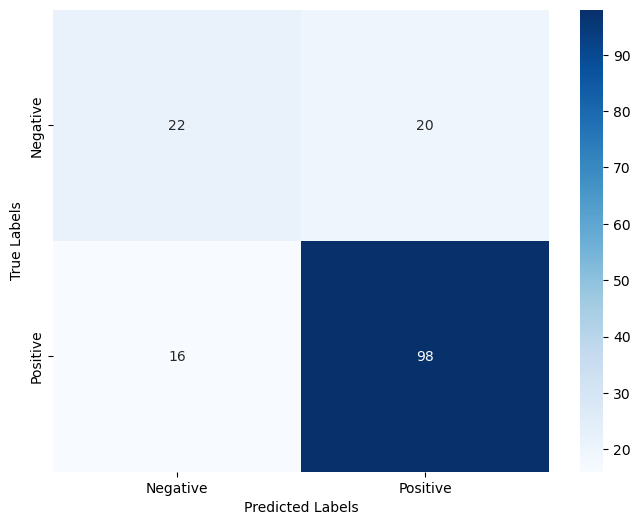

In [54]:
cm = confusion_matrix(test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()